# Problem statement

A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 


In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.


They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

- **Which variables are significant in predicting the demand for shared bikes**.
- **How well those variables describe the bike demands**
Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors. 


**Business Goal:**

You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 




# Dataset characteristics

- **instant**: record index
- **dteday** : date
- **season** : season (1:spring, 2:summer, 3:fall, 4:winter)
- **yr** : year (0: 2018, 1:2019)
- **mnth** : month ( 1 to 12)
- **holiday** : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- **weekday** : day of the week
- **workingday** : if day is neither weekend nor holiday is 1, otherwise is 0.
- **weathersit** : 
>- 1: **Clear**, Few clouds, Partly cloudy, Partly cloudy
>- 2: **Mist** + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
>- 3: **Light (hazard?)** Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
>- 4: **Extreme** Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp** : temperature in Celsius
- **atemp**: feeling temperature in Celsius
- **hum**: humidity
- **windspeed**: wind speed
- **casual**: count of casual users
- **registered**: count of registered users
- **cnt**: count of total rental bikes including both casual and registered

***
# Outline

### 0. Import libraries
### 1. Data quality check
### 2. EDA
-  2.1 Processing data for EDA
-  2.2 Univariate and Multivariate EDA
-  2.3 Summary of EDA
### 3. Data preparation
-  Fix outliers detected during eda
-  Drop unnecessary columns
-  Create dummy variable
-  Train/Test Split
-  Feature scaling
### 4. Building model
-  4.1 Simple models (1 feature)
-  4.2 Multiple linear regression model 1 (feature selection using RFE with unscaled data)
-  4.3 Multiple linear regression model 2 (feature selection using RFE with min-max scaled data)
-  4.4 Multiple linear regression model 3 (feature selection using RFE with standardized data)

### 5. Conclusion
-  5.1 Summary
-  5.2 Model selection and interpretation
***

# 0. Import

In [94]:
# bread and butter
import numpy as np   
from numpy import mean,absolute,sqrt
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt                                   
import seaborn as sns
import warnings; 
# warnings.filterwarnings('ignore') 
import time

# pandas settings
# all columns, limit 200 rows
pd.set_option("display.max_columns", None) 
pd.set_option("display.max_rows", 200)
# round up DISPLAY 4 decimal
# pd.options.display.float_format = "{:,.4f}".format

# data preprocessing
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, cross_val_predict

# linear regression
from sklearn.linear_model import LinearRegression
import scipy
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.feature_selection import RFE

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.stats.api import het_goldfeldquandt

In [95]:
from platform import python_version

# Compare currently installed versions
print('Compare current versions of installed libraries to the ones used to create this notebook:')
print(f'Current Python version: {python_version()}')
print('Used Python version   : 3.9.15', end=' ')
print('----> Matched.') if python_version() == '3.9.15' else print('----> Not matched.')   
print('*'*70)
used_library_version = [
    (pd, 'Pandas','1.5.2'), 
    (np,'Numpy','1.22.3'), 
    (matplotlib, 'Matplotlib','3.6.2'), 
    (sns, 'Seaborn','0.12.1'),
    (scipy, 'Scipy', '1.7.3'),
    (sklearn, 'sklearn', '1.1.3'),
    (statsmodels, 'statsmodels' ,'0.13.2')
]

compare_version = pd.DataFrame({
    '  Library':        [lib_name                    for lib, lib_name, used_ver in used_library_version],
    '  Installed ver.': [lib.__version__             for lib, lib_name, used_ver in used_library_version],
    '  Used ver.':      [used_ver                    for lib, lib_name, used_ver in used_library_version],
    '  Version match?': [lib.__version__ == used_ver for lib, lib_name, used_ver in used_library_version]
    })
print(compare_version)

Compare current versions of installed libraries to the ones used to create this notebook:
Current Python version: 3.9.15
Used Python version   : 3.9.15 ----> Matched.
**********************************************************************
       Library   Installed ver.   Used ver.    Version match?
0       Pandas            1.5.2       1.5.2              True
1        Numpy           1.22.3      1.22.3              True
2   Matplotlib            3.6.2       3.6.2              True
3      Seaborn           0.12.1      0.12.1              True
4        Scipy            1.7.3       1.7.3              True
5      sklearn            1.1.3       1.1.3              True
6  statsmodels           0.13.2      0.13.2              True


- For precaution, I tried to use the most up-to-date method and avoided using soon-to-be deprecated syntax (as stated by FutureWarning if encountered) to the best of my ability, with libraries version mentioned above.
- In the very rare case that you run into any error, please try updating/reverting your libraries' versions to the "Used ver." listed above, as older or newer libraries version might have unsupported/deprecated syntax (especially for Matplotlib and Seaborn).

# 1. Data quality check

In [96]:
df = pd.read_csv('day.csv')
df_copy = df.copy()
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,27-12-2019,1,1,12,0,5,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,1,1,12,0,6,0,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,1,1,12,0,0,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,1,1,12,0,1,1,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796


### Datatype

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


### Null value

In [98]:
df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

### Summery statistics

In [99]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,730.0,365.500000,210.877136,1.000000,183.250000,365.500000,547.750000,730.000000
season,730.0,2.498630,1.110184,1.000000,2.000000,3.000000,3.000000,4.000000
yr,730.0,0.500000,0.500343,0.000000,0.000000,0.500000,1.000000,1.000000
mnth,730.0,6.526027,3.450215,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,730.0,0.028767,0.167266,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,730.0,2.995890,2.000339,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,730.0,0.690411,0.462641,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,730.0,1.394521,0.544807,1.000000,1.000000,1.000000,2.000000,3.000000
temp,730.0,20.319259,7.506729,2.424346,13.811885,20.465826,26.880615,35.328347
atemp,730.0,23.726322,8.150308,3.953480,16.889713,24.368225,30.445775,42.044800


### Duplicates

In [100]:
df.duplicated().sum()

0

In [101]:
# exclude instant, just to really make sure
df.loc[:,'season':'cnt'].duplicated().sum()

0

### Summary
- There is no missing value or duplicated entries
- dteday is in wrong format (should be datetime)
- Most of the values seems normal, nothing out of range except for **humidity (min = 0).**
- weathersit's max value is 3, so no instance of extreme weather (4). If we build a model with current data, it will not be able to predict reliably for extreme weather as we have no data available for such occurence.
- target variable: there are days as low as 22

# 2. EDA

## 2.1 Processing for eda

In [102]:
# rename some column for readability
df = df.rename(columns = {
    'weathersit': 'weather', 
    'hum': 'humidity', 
})

In [103]:
# convert dteday to datetime
df['dteday'] = pd.to_datetime(df['dteday'], dayfirst=True)

In [104]:
# convert year to correct year
df.yr = df.yr.map({0: 2018, 1:2019})

In [105]:
# convert season to categorical
df.season = df.season.map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})
df.season.value_counts()

Fall      188
Summer    184
Spring    180
Winter    178
Name: season, dtype: int64

In [106]:
# weekday as number (0-6) to name (Mon, Tue,...)
df.weekday = df.dteday.dt.day_name().str[:3]
df.weekday

0      Mon
1      Tue
2      Wed
3      Thu
4      Fri
      ... 
725    Fri
726    Sat
727    Sun
728    Mon
729    Tue
Name: weekday, Length: 730, dtype: object

In [107]:
# weather

weather_condition = {
    1: 'Clear',
    2: 'Cloudy',
    3: 'Light_rain_snow',
    4: 'Extreme'
} # naming for analysis purpose only, refer to data dictionary for full description of weather condition

df.weather = df.weather.map(weather_condition)

In [108]:
# casual:registered ratio
df['casual_to_reg_ratio'] = df.casual/df.registered

**Make backup**

In [109]:
df_eda = df.copy()

## 2.2 Univariate and Multivariate EDA

### Count usage

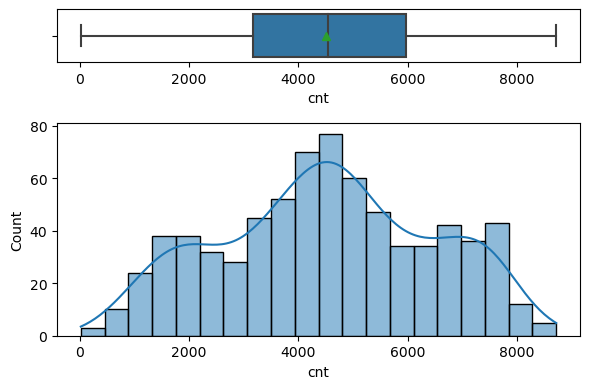

In [110]:
fig, (ax1,ax2) = plt.subplots(nrows=2,  height_ratios = (1,4), figsize=(6,4))
sns.boxplot(x=df.cnt,showmeans=True, ax=ax1)
sns.histplot(x=df.cnt, kde=True, bins= 20, ax=ax2)
plt.tight_layout()
plt.show()

- Mean usage is about 4500, IQR is about 3000-6000
- There is a large variance between the max and min value (from near 0 to over 8000)
- There's no observable outlier, although there are days with very few usage (near to 0)

**Days with very low number of bikes rented.**

In [111]:
df[df.cnt <50]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,cnt,casual_to_reg_ratio
666,667,2019-10-29,Winter,2019,10,0,Tue,1,Light_rain_snow,18.04,21.97,88.0,23.9994,2,20,22,0.1


Low rented bike on this day could be due to the rain. We will look at detailed weather category later.

### Trend in usage with days in operation

**Is there a trend in usage w/ days in operation**

<AxesSubplot: xlabel='instant', ylabel='cnt'>

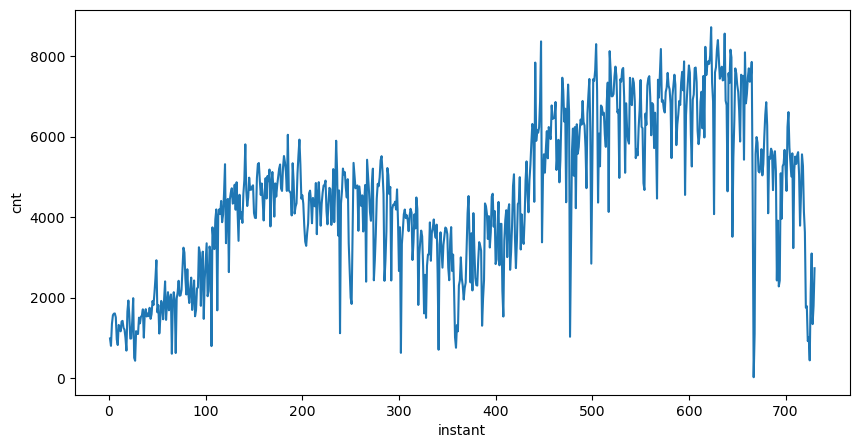

In [112]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df, y='cnt', x='instant')

<AxesSubplot: xlabel='instant', ylabel='cnt'>

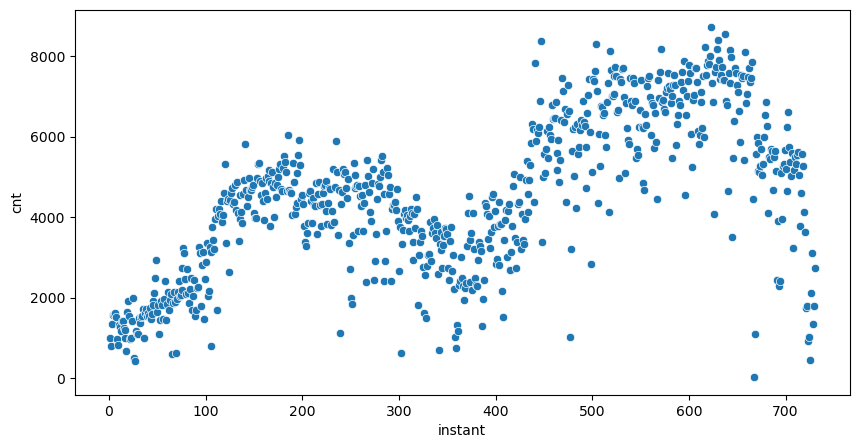

In [113]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, y='cnt', x='instant')

- There's seem to be a seasonal upward trend and
- In each year, usage reached its peak mid year.
- The second year has higher peak than the first, shows a positive trend in service adoption.
- That being said, the lowest point during 2019 is even lower than that in 2018. This shows a somewhat unstable demand, which can be drastically affected by many factors.

### See weekly usage over time

In [114]:
# datetime to week of year
df['week_since_beginning'] = df.dteday.dt.isocalendar().week

In [115]:
# see last week of 2018
df[['instant','dteday','yr','week_since_beginning']][df.yr == 2018].tail()

,instant,dteday,yr,week_since_beginning
360,361,2018-12-27,2018,52
361,362,2018-12-28,2018,52
362,363,2018-12-29,2018,52
363,364,2018-12-30,2018,52
364,365,2018-12-31,2018,1


In [116]:
# see last week of 2019
df[['instant','dteday','yr','week_since_beginning']][df.yr == 2019].tail()

,instant,dteday,yr,week_since_beginning
725,726,2019-12-27,2019,52
726,727,2019-12-28,2019,52
727,728,2019-12-29,2019,52
728,729,2019-12-30,2019,1
729,730,2019-12-31,2019,1


- The last week of 2018 count back to 1 instead of 53, and the last week of 2019 only has 2 days
- We will combine the last day of 2018 to the first week of 2019, and exclude the last 2 days of 2019

In [117]:
# if week_since_beginning = 1 and month is 12, set the week to 53
df['week_since_beginning'][(df.week_since_beginning==1) & (df.mnth==12)] = 53

# +52 to the week of 2019
df['week_since_beginning'][df.yr==2019] = df['week_since_beginning'][df.yr==2019] + 52

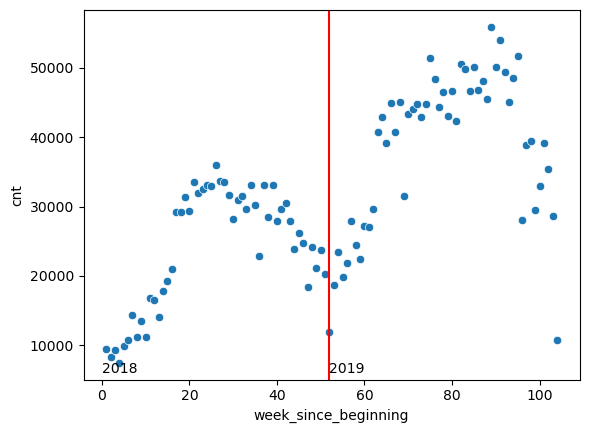

In [118]:
# group the usage count by week
df_week = df.groupby('week_since_beginning').sum(numeric_only = True)
df_week = df_week.reset_index()
df_week.week_since_beginning = df_week.week_since_beginning.astype(int)

# exclude the last (incomplete) week
df_week = df_week[df_week.week_since_beginning != df_week.week_since_beginning.max()]

# plot the usage data by week
sns.scatterplot(data=df_week, y='cnt', x='week_since_beginning')
plt.axvline(52, color='r')
plt.annotate('2018', xy=(0,6_000))
plt.annotate('2019', xy=(52,6_000))
plt.show()

- Besides the first few weeks, the lowest week is the last week of the year. It makes sense as people want to stay in during Christmas and new year's eve.

### Usage by seasons

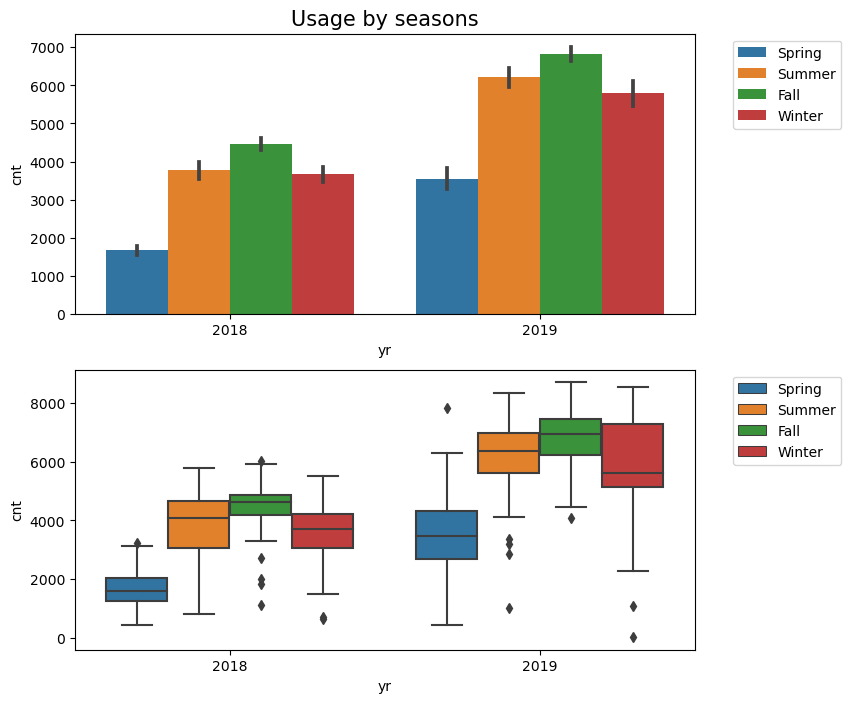

In [119]:
fig, [ax1,ax2] = plt.subplots(nrows=2, figsize=(8,8))
sns.barplot(data=df, y='cnt', x='yr', hue='season', ax=ax1)
ax1.legend(bbox_to_anchor=(1.05, 1))
ax1.set_title('Usage by seasons', size=15)
sns.boxplot(data=df, y='cnt', x='yr', hue='season', ax=ax2)
ax2.legend(bbox_to_anchor=(1.05, 1))
plt.show()

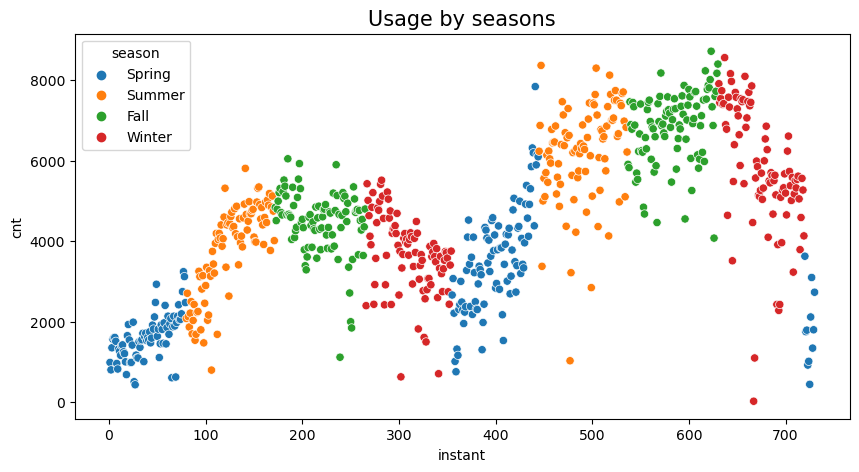

In [120]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, y='cnt', x='instant', hue='season')
plt.title('Usage by seasons', size=15)
plt.show()

### Usage by month

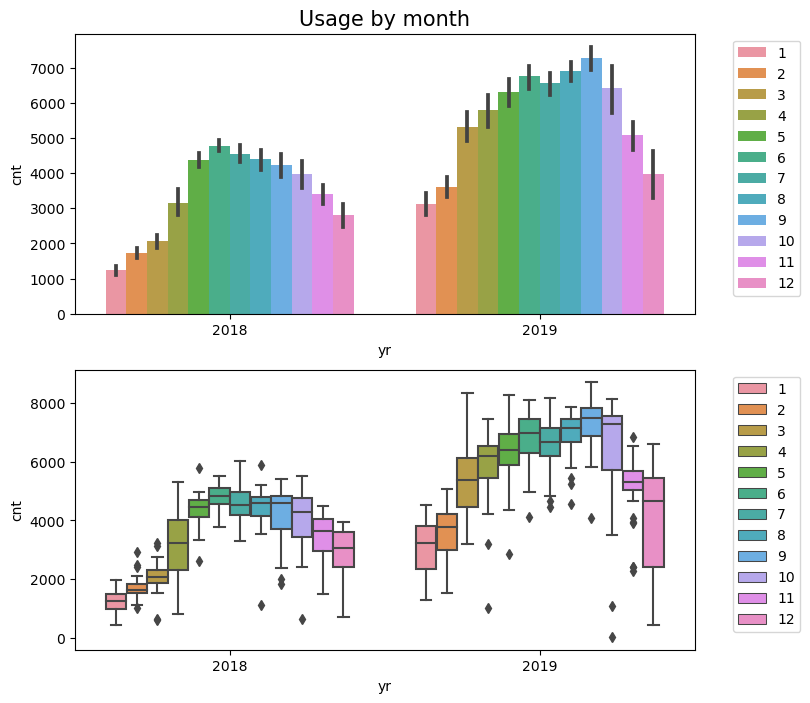

In [121]:
fig, [ax1,ax2] = plt.subplots(nrows=2, figsize=(8,8))
sns.barplot(data=df, y='cnt', x='yr', hue='mnth', ax=ax1)
ax1.legend(bbox_to_anchor=(1.05, 1))
ax1.set_title('Usage by month', size=15)
sns.boxplot(data=df, y='cnt', x='yr', hue='mnth', ax=ax2)
ax2.legend(bbox_to_anchor=(1.05, 1))
plt.show()

#### There are outliers in Oct, 2019. Let's investigate that.

<AxesSubplot: ylabel='cnt'>

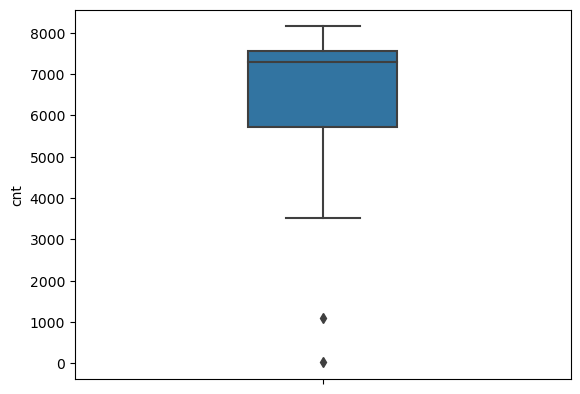

In [122]:
sns.boxplot(data=df[(df.yr==2019) & (df.mnth==10)], y='cnt', width=0.3)

It has a mean of around 7200 and IQR from 5800~7500, yet there are at least 2 days where usage drop to around 1000 and 0.

**Try to find the outliers**

In [123]:
df[(df.yr==2019) & (df.mnth==10) &(df.cnt<2000)]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,cnt,casual_to_reg_ratio,week_since_beginning
666,667,2019-10-29,Winter,2019,10,0,Tue,1,Light_rain_snow,18.040000,21.97000,88.0000,23.999400,2,20,22,0.100000,96
667,668,2019-10-30,Winter,2019,10,0,Wed,1,Cloudy,13.045462,15.49545,82.5455,14.271603,87,1009,1096,0.086224,96


In [124]:
instant_n = 667
features = ['instant','dteday', 'season', 'holiday','weekday','weather','windspeed','cnt']
df[df.instant.isin(range(instant_n-5,instant_n+5,1))][features]

,instant,dteday,season,holiday,weekday,weather,windspeed,cnt
661,662,2019-10-24,Winter,0,Thu,Clear,4.876206,7693
662,663,2019-10-25,Winter,0,Fri,Cloudy,8.333125,7359
663,664,2019-10-26,Winter,0,Sat,Cloudy,8.875289,7444
664,665,2019-10-27,Winter,0,Sun,Cloudy,15.791364,7852
665,666,2019-10-28,Winter,0,Mon,Cloudy,26.666536,4459
666,667,2019-10-29,Winter,0,Tue,Light_rain_snow,23.999400,22
667,668,2019-10-30,Winter,0,Wed,Cloudy,14.271603,1096
668,669,2019-10-31,Winter,0,Thu,Cloudy,11.166689,5566
669,670,2019-11-01,Winter,0,Fri,Cloudy,10.542182,5986
670,671,2019-11-02,Winter,0,Sat,Clear,17.833725,5847


- Seems like the sudden drop in usage is due to a suddent rain. The average before this is around 7000, then drop to 22 on the day of the rain.

### Usage on holiday

In [125]:
print(f'Holidays in 2018: {df.holiday[df.yr==2018].sum()}')
print(f'Holidays in 2019: {df.holiday[df.yr==2019].sum()}')

Holidays in 2018: 10
Holidays in 2019: 11


In [126]:
df[['holiday','cnt']].groupby('holiday').mean()

,cnt
holiday,
0,4530.90268
1,3735.00000


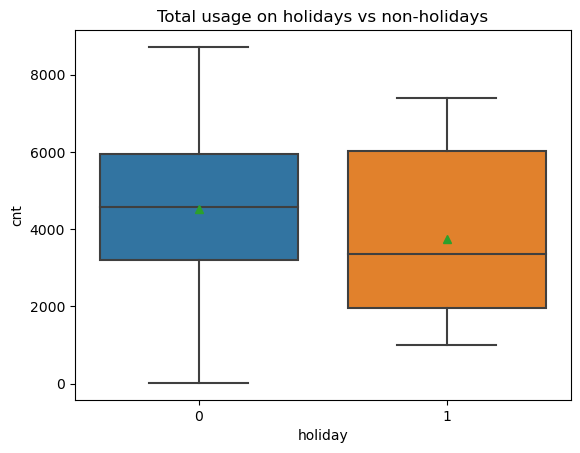

In [127]:
plt.title('Total usage on holidays vs non-holidays')
sns.boxplot(data=df, y='cnt', x='holiday', showmeans=True)
plt.show()

Text(0.5, 1.0, 'Casual:Registered ratio on holidays vs non-holidays')

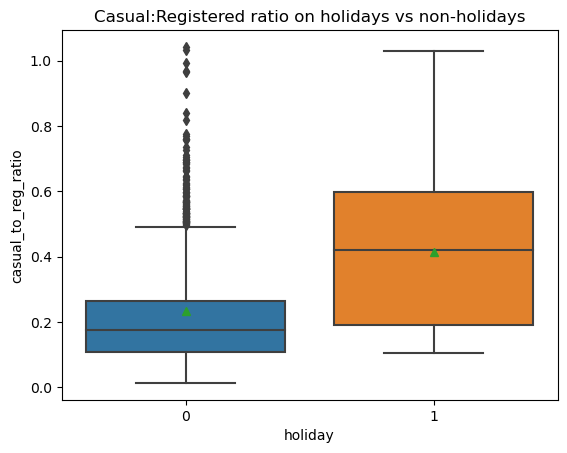

In [128]:
sns.boxplot(df, x='holiday', y='casual_to_reg_ratio', showmeans=True)
plt.title('Casual:Registered ratio on holidays vs non-holidays')


- Holidays see a lower mean of total usage.
- Holidays has a much higher ratio of casual:registered, means that people tends to try out the service on holidays.

### Usage by weekday and working day

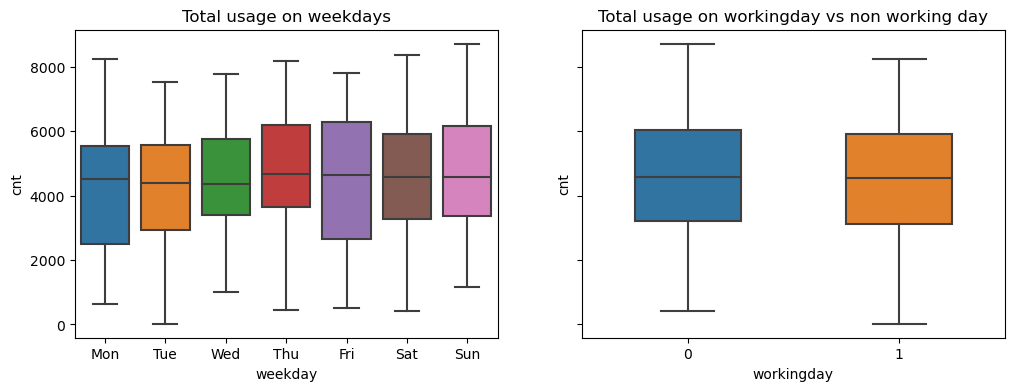

In [129]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12,4), sharey=True)
sns.boxplot(data=df, y='cnt', x= 'weekday', ax=ax1)
ax1.set_title('Total usage on weekdays')

sns.boxplot(data=df, y='cnt', x= 'workingday', ax=ax2, width=0.5)
ax2.set_title('Total usage on workingday vs non working day', )
plt.show()

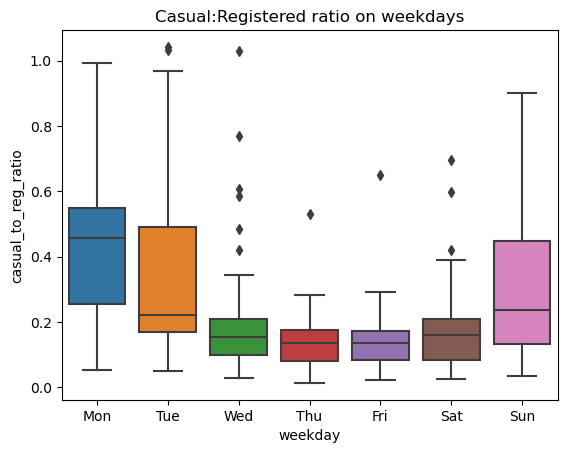

In [130]:
sns.boxplot(df, x='weekday', y='casual_to_reg_ratio')
plt.title('Casual:Registered ratio on weekdays')
plt.show()

- The total usage is similar accross all weekdays
- On Sunday and Monday, the ratio of casual users to registered ones are higher than the rest. This means that people tends to try out the service on Sunday and Monday.

### Usage by weather

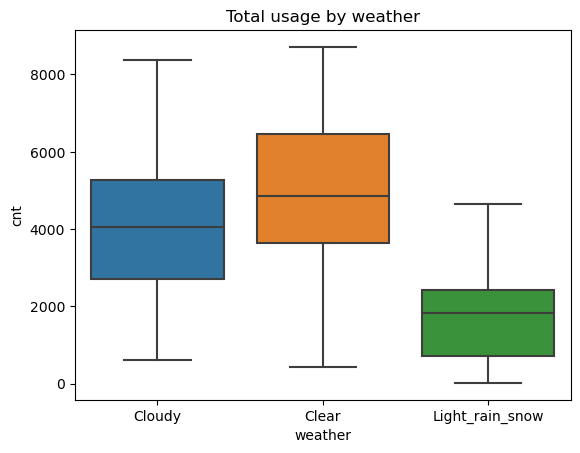

In [131]:
sns.boxplot(data=df, y="cnt", x= 'weather')
plt.title('Total usage by weather')
plt.show()

<AxesSubplot: xlabel='instant', ylabel='cnt'>

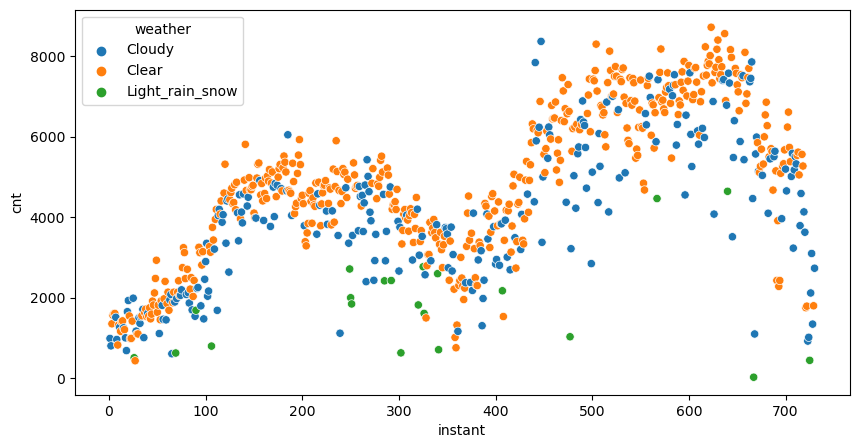

In [132]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, y='cnt', x='instant', hue='weather')

- There seems to be a correlation between weather condition and usage
- Days with light rain/snow see a drop in usage compared to clear or cloudy

### Numerical features

- atemp, by definition, is derived from temp, humidity and windspeed. 
- casual and registered are part of target variable. 

We can ignore these 2 here.

In [133]:
df[['temp','humidity','windspeed','casual', 'registered', 'cnt']].corr()

,temp,humidity,windspeed,casual,registered,cnt
temp,1.000000,0.128565,-0.158186,0.542731,0.539436,0.627044
humidity,0.128565,1.000000,-0.248506,-0.075211,-0.089212,-0.098543
windspeed,-0.158186,-0.248506,1.000000,-0.167995,-0.217914,-0.235132
casual,0.542731,-0.075211,-0.167995,1.000000,0.394137,0.672123
registered,0.539436,-0.089212,-0.217914,0.394137,1.000000,0.945411
cnt,0.627044,-0.098543,-0.235132,0.672123,0.945411,1.000000


<AxesSubplot: >

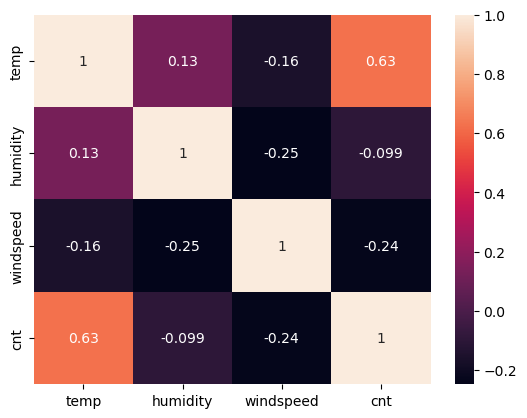

In [134]:
# correlation heatmap
sns.heatmap(df[['temp','humidity','windspeed', 'cnt']].corr(), annot=True)

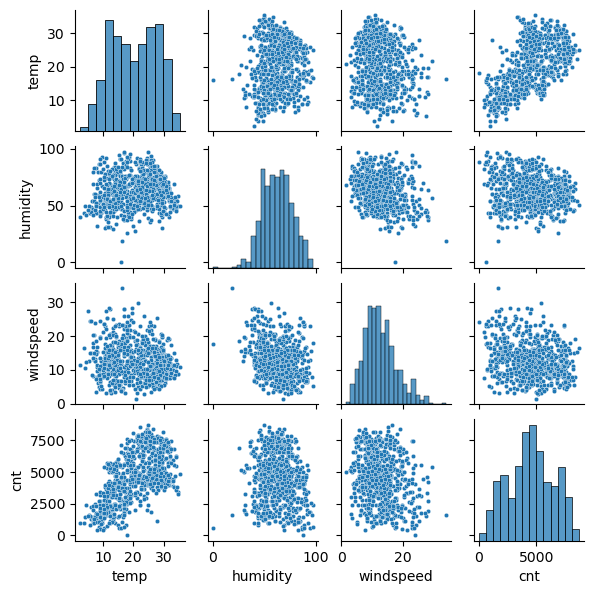

In [135]:
sns.pairplot(df[['temp','humidity','windspeed', 'cnt']], height=1.5, plot_kws={"s": 10})

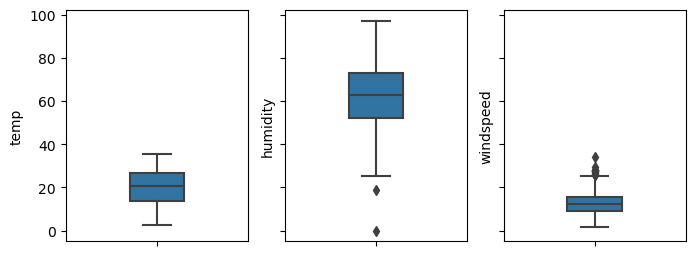

In [136]:
fig, [ax1,ax2,ax3] = plt.subplots(ncols=3, figsize=(8,3),sharey=True) #sharey=True, sharex=True

for ax, feature in zip([ax1,ax2,ax3], ['temp','humidity','windspeed']):
    ax = sns.boxplot(data=df, y=feature, ax=ax, width=0.3)

**By weather condition**

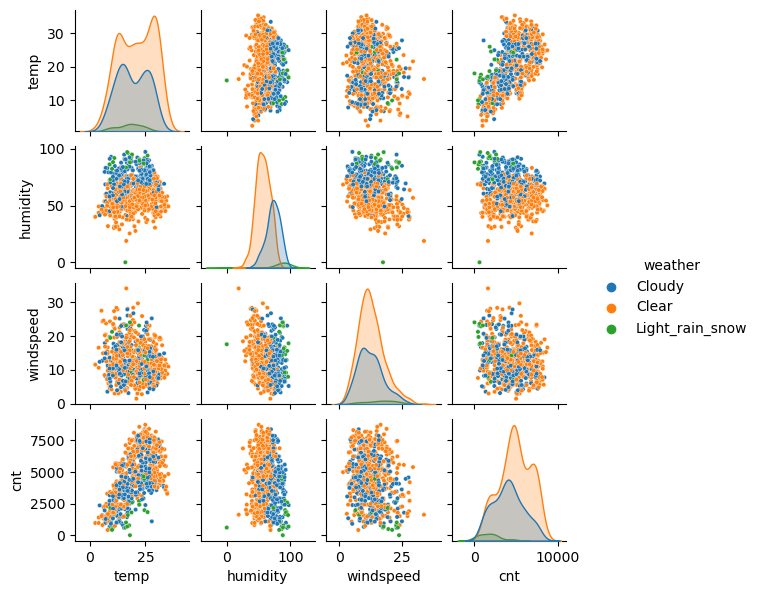

In [137]:
sns.pairplot(df[['temp','humidity','windspeed', 'cnt', 'weather']], hue='weather', height=1.5, plot_kws={"s": 10})

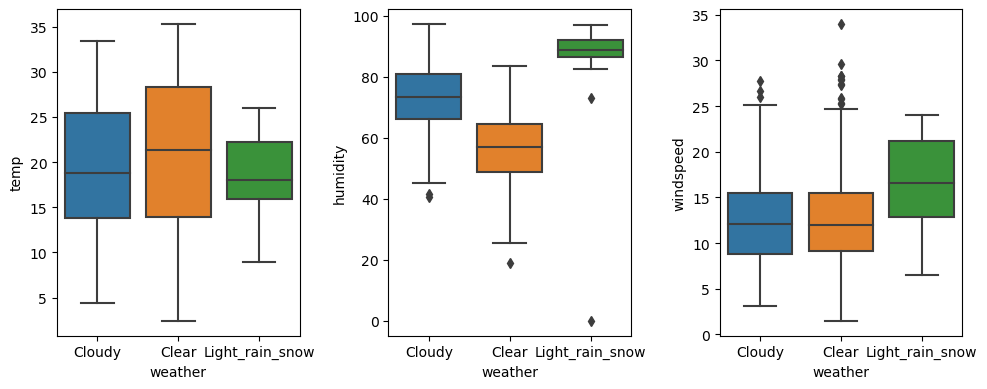

In [138]:
plt.figure(figsize=(10,4))
for index, feature in enumerate(['temp','humidity','windspeed']):
    ax = plt.subplot(1, 3, index + 1)
    sns.boxplot(data=df, y=feature, x='weather', ax=ax)
plt.tight_layout()

**By season**

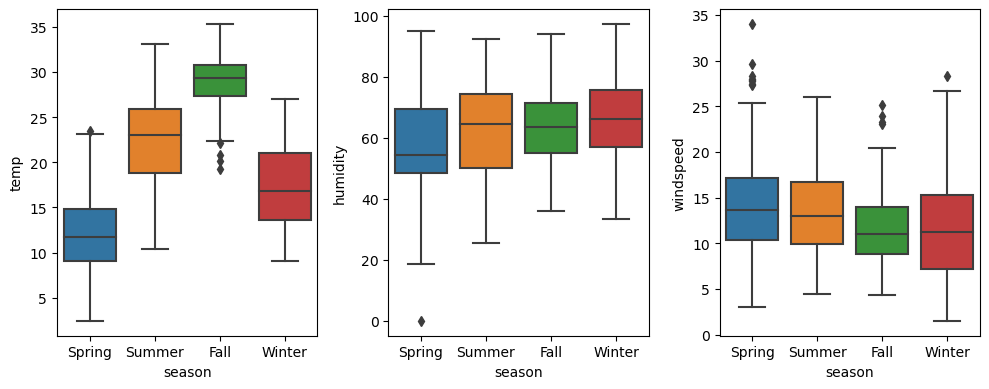

In [139]:
plt.figure(figsize=(10,4))
for index, feature in enumerate(['temp','humidity','windspeed']):
    ax = plt.subplot(1, 3, index + 1)
    sns.boxplot(data=df, y=feature, x='season', ax=ax)
plt.tight_layout()

<AxesSubplot: xlabel='season', ylabel='cnt'>

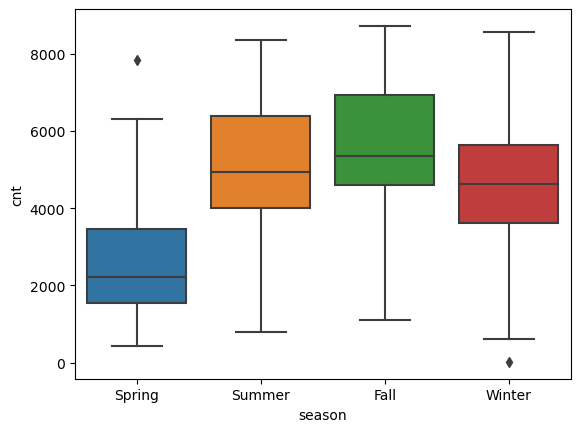

In [140]:
# usage by season
sns.boxplot(data=df, y='cnt', x='season')

In [141]:
df.season.value_counts()

Fall      188
Summer    184
Spring    180
Winter    178
Name: season, dtype: int64

### Outliers


- There's outlier in humidity (at 0)

#### Outlier in humidity

It is very unlikely to have 0% humidity in nature, so this value could be a mistake in input.

In [142]:
df[df.humidity == df.humidity.min()]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,cnt,casual_to_reg_ratio,week_since_beginning
68,69,2018-03-10,Spring,2018,3,0,Sat,0,Light_rain_snow,15.952731,19.2834,0.0,17.545759,46,577,623,0.079723,10


## 2.3 Summary of EDA

- There is a high fluctuation in target variable, from as low as near 0 to over 8000
- Target variable show strong correlation to weather condition, season and temerature.
- Demand is highest in Clear weather, and drops in rain/snow weather.
- Fall and Summer shows highest usage, while Spring has lowest usage.
- Usage is generally lower on holiday
- Casual\New users tend to use the service on holiday and Sunday/Monday. It could be a good oppotunity to convert them to registered users.
- There are outlier that is very likely misinputs.

# 3. Data preparation

### Fix outliers detected during eda

In [143]:
# Outlier in humidity
# fill hum == 0 with mean of hum where the weather is Light rain/snow
df.loc[df.humidity == 0,'humidity'] = df.humidity[df.weather=='Light_rain_snow'].mean().astype(int)


### Drop unnecessary columns

In [144]:
df = df.drop(columns=['instant','week_since_beginning', 'dteday', 'atemp', 'casual', 'registered', 'casual_to_reg_ratio'])

### Create dummy variables

The shorter way to convert all categorical columns to dummies would be:

In [145]:
# dummy_features = ['season', 'yr', 'mnth', 'weekday', 'weather']  
# df = pd.get_dummies(data = df, columns = dummy_features, drop_first = True)

But since I want to specify the reference category (ie which columns to drop) for easier interpretability, instead of letting pandas drop the first label alphabetically, hence the extra long code below

In [146]:
# convert year and month to dummies
df = pd.get_dummies(data = df, columns = ['yr', 'mnth'], drop_first = True)

# convert season, weekday and weather to dummies
dummies_season = pd.get_dummies(data = df['season']).drop(columns='Spring')
dummies_weekday = pd.get_dummies(data = df['weekday']).drop(columns='Mon')
dummies_weather = pd.get_dummies(data = df['weather']).drop(columns='Clear')
df.drop(columns=['season', 'weekday', 'weather'], inplace=True)

df = pd.concat([df,dummies_season,dummies_weekday,dummies_weather], axis=1)

df.head()

,holiday,workingday,temp,humidity,windspeed,cnt,yr_2019,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,Fall,Summer,Winter,Fri,Sat,Sun,Thu,Tue,Wed,Cloudy,Light_rain_snow
0,0,1,14.110847,80.5833,10.749882,985,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,14.902598,69.6087,16.652113,801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,0,1,8.050924,43.7273,16.636703,1349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,8.200000,59.0435,10.739832,1562,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,1,9.305237,43.6957,12.522300,1600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### Make a copy

In [147]:
# make a copy
df_preprocessed = df.copy()
df_preprocessed.to_csv('data_preprocessed.csv', index=False)

### Train/Test Split

In [148]:
# load backup data if needed
# df = pd.read_csv('data_preprocessed.csv')

In [149]:
X = df.drop(columns='cnt')
X = sm.add_constant(X)

y = df.cnt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

# Check shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((584, 29), (584,), (146, 29), (146,))

### Feature scaling

- Feature scaling is not really necessary here, since the numerical features are loosely in the same range. 
- If one feature was 0-10 and another feature is 0 - 1,000,000, then scaling would be required.
- Not scaling the data here helps with interpreting and presenting coefficients. It is easier to understand '1 celsius degree increased in temperature lead to xx increase/decrease in rented bikes' than '1 standard deviation increased in temperature lead to xx change in target'
- While feature scaling does not affect results, p-values or VIF of variables, I fould that it does change how RFE selects the best features. In my test, n features selected by RFE changed with different scaling methods. Why this happened is a topic for later research.
- In this submission, I try out all 3 sets of features selected by RFE on unscaled, normalized and standardized data.

# 4. Building model

## 4.1 Simple models

In [150]:
simple_model = [
    ('Temp', ['temp']),
    ('Wind speed', ['windspeed']),
    ('Humidity', ['humidity']),
    ('Season', ['Fall', 'Summer', 'Winter']),
    ('Weather', ['Cloudy', 'Light_rain_snow']),
    ('Working day', ['workingday']),
    ('Year', ['yr_2019'])
]
model_number = 1

for features_name, features in simple_model:
    # model name
    model_title = f'MODEL {model_number}: {features_name} only'
    indent = int( (77 - len(model_title))/2)
    print(' '*indent + model_title, end='\n\n')
    
    # model summary
    model = sm.OLS(y_train, X_train[['const'] + features]).fit()
    model_number += 1
    print(model.summary())
    print(('-'*90 + '\n'*3))

                             MODEL 1: Temp only

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     373.2
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           1.27e-64
Time:                        23:06:24   Log-Likelihood:                -5105.0
No. Observations:                 584   AIC:                         1.021e+04
Df Residuals:                     582   BIC:                         1.022e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

**Conclusion:**
- Temp model has highest R^2 (0.391) . By this model, each 1 degree increase correlated with 150 increase in usage count.
- Season has the second highest R2 (0.331). By this model, Spring is the season with lowest usage count and Fall is where the usage increase most, followed by Summer and Winter
- Year model's R^2 is 0.330, indicate that year can help explain the target variable well.







## 4.2 Multiple linear regression model 1 (feature selection using RFE with unscaled data)

### Function for RFE, VIF and model performance metrics

In [151]:
# Function to select n features using RFE
# work for both original data and scaled data
def rfe_top_features(X_data, y_data, n_features):
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=n_features)
    rfe.fit(X_data,y_data) 
    result = pd.DataFrame({'ranking': rfe.ranking_, 'features': X_data.columns}).sort_values('ranking')
    
    print(f'Top {n_features} features:')
    # print(rfe.get_feature_names_out().tolist())
    return rfe.get_feature_names_out().tolist()

In [152]:
# Function to check VIF
# work for both original data and scaled data

def checking_vif(data):
    result = pd.DataFrame()
    result['feature'] = data.columns

    # Calculating VIF for each feature
    result['VIF'] = [
        vif(data.values, i) for i in range(len(data.columns))
    ]
    result['VIF'] = result['VIF'].apply(lambda x: round(x,2))
    return result.sort_values('VIF', ascending=False)

In [153]:
# Function for calculating performance metrics (R^2, MSE, MAE)
def model_performance(olsmodel, X_train_data, X_test_data): # X_train_data looks like: X_train[['const'] + top_features]
    yhat_train = olsmodel.predict(X_train_data)
    yhat_test  = olsmodel.predict(X_test_data)
    prediction_sets = [(y_train, yhat_train), (y_test, yhat_test)]
    
    df_performance = pd.DataFrame({
        'Metrics': ['Train', 'Test'],
        'R-squared': [r2_score(y_true, yhat) for y_true, yhat in prediction_sets],
        'MSE': [mean_squared_error(y_true, yhat) for y_true, yhat in prediction_sets],
        'MAE': [mean_absolute_error(y_true, yhat) for y_true, yhat in prediction_sets]
    })
    return df_performance

### Feature selection with RFE

RFE can be used to select the best n features, but we have to decide how many n features we need. The code below will calculate with each n features, what is the highest VIF value among said n features to provide us a starting point.

In [154]:
max_vif_values = []
model = LinearRegression()

# loop to calculate max VIF among n features
for n_features in range(2, X_train.shape[1] + 1):
    rfe = RFE(model, n_features_to_select = n_features)
    rfe.fit(X_train, y_train) 
    # top features selected
    top_n_features = rfe.get_feature_names_out(X_train.columns).tolist()
    # calculate the highest vif values among the selected features
    vif_for_n_features = [vif(X_train[['const'] + top_n_features].values, i) for i in range(n_features+1)]
    max_vif_value = pd.Series(vif_for_n_features[1:]).max()
    max_vif_values = max_vif_values + [max_vif_value]
    if max_vif_value > 50:
        break

df_result = pd.DataFrame({
    'n_features': range(2, len(max_vif_values) + 2),
    'max_vif_value': max_vif_values
})
df_result.sort_values('n_features', ascending=False)

,n_features,max_vif_value
16,18,52.774324
15,17,8.069822
14,16,8.068482
13,15,8.065417
12,14,8.050711
11,13,8.049969
10,12,5.963988
9,11,1.930872
8,10,1.584706
7,9,1.335745


Text(0.5, 1.0, 'Highest VIF value corresponding to n features selected')

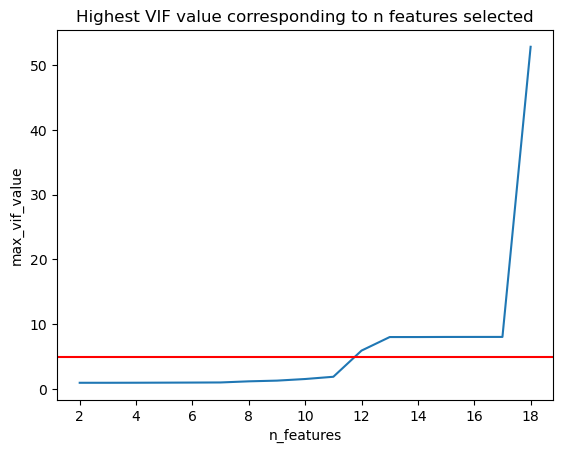

In [155]:
sns.lineplot(data=df_result, x='n_features', y='max_vif_value')
plt.axhline(5, color='r')
plt.title('Highest VIF value corresponding to n features selected')

**Observation:**
- From 12 features, we start to see there are features with VIF of 6. Let's start RFE selection from 11.

**Calculate the top 11 features with RFE**

In [156]:
top_features = rfe_top_features(X_train, y_train, 11)
top_features

Top 11 features:


['yr_2019',
 'mnth_3',
 'mnth_4',
 'mnth_5',
 'mnth_6',
 'mnth_7',
 'mnth_8',
 'mnth_9',
 'mnth_10',
 'Winter',
 'Light_rain_snow']

**Check VIF of 14 features above**

In [157]:
checking_vif(X_train[['const'] + top_features])

,feature,VIF
0,const,5.95
10,Winter,1.93
9,mnth_10,1.42
2,mnth_3,1.31
7,mnth_8,1.30
5,mnth_6,1.29
6,mnth_7,1.29
4,mnth_5,1.28
3,mnth_4,1.24
8,mnth_9,1.17


**Observation:**
All variables have VIF less than 5, indicating little to no multicollinearity.

### Build model 1

In [158]:
model1 = sm.OLS(y_train,X_train[['const']+ top_features]).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     165.0
Date:                Tue, 28 Feb 2023   Prob (F-statistic):          2.37e-169
Time:                        23:06:25   Log-Likelihood:                -4832.5
No. Observations:                 584   AIC:                             9689.
Df Residuals:                     572   BIC:                             9741.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1479.5699     96.813     

**Observation:**
- All variables's p-value are < 0.05, meaning they are all statistically significant.

### Cross validation and checking assumption

#### Function to validate assumptions

In [159]:
def validate_assumption(olsmodel, X_train_data, X_test_data): # X_train_data looks like X_train[['const'] + top_features]
    
    # train/test performance
    yhat_train = olsmodel.predict(X_train_data)
    yhat_test  = olsmodel.predict(X_test_data)
    prediction_sets = [(y_train, yhat_train), (y_test, yhat_test)]
    
    # calculate R^2, MSE, MAE
    train_test_performance = pd.DataFrame({
        'Metrics': ['Train', 'Test'],
        'R-squared': [r2_score(y_true, yhat) for y_true, yhat in prediction_sets],
        'MSE': [mean_squared_error(y_true, yhat) for y_true, yhat in prediction_sets],
        'MAE': [mean_absolute_error(y_true, yhat) for y_true, yhat in prediction_sets]
    })
    
    # kfold crossval with scikit learn
    model = LinearRegression()
    cv = KFold(n_splits=5, random_state=14, shuffle=True)
    scores = cross_validate(model, X[X_train_data.columns[1:]], y, scoring= ['r2','neg_mean_absolute_error','neg_mean_squared_error'],cv=cv)
    cross_val_result = pd.DataFrame(scores)
    cross_val_result.columns = ['fit_time', 'score_time', 'R_squared', 'MAE', 'MSE']
    # calculate mean R^2, MSE, MAE of kfold cross validation
    mean_r2 = [cross_val_result.R_squared.mean()]
    mean_mae = [cross_val_result.MAE.abs().mean()]
    mean_mse = [cross_val_result.MSE.abs().mean()]
    cross_val_performance = pd.DataFrame({'Metrics': 'Cross_val', 'R-squared': mean_r2, 'MSE': mean_mse, 'MAE': mean_mae})
    print('K fold cross validation: ')
    print(pd.concat([train_test_performance, cross_val_performance], axis=0))
    print('\n' + '-'*50)
    
    # check multicollinearity
    print('Check multicollinearity')
    print(checking_vif(X_train[['const'] + top_features]).set_index('feature'))
    print('\n' + '-'*50)
    
    # Mean of residual
    residuals = olsmodel.resid
    print(f'Mean residual: {np.mean(residuals):.4f}  ({np.mean(residuals)})')
    print('\n' + '-'*50)
    
    # Goldfeld–Quandt test of homoscedasticity
    f_stat, p_value, ordering = het_goldfeldquandt(residuals, X_train_data)
    print('Goldfeld–Quandt test of homoscedasticity')
    print('-- Hypothesis:')
    print('-- H0: Residuals are homoscedastic')
    print('-- H1: Residuals have heteroscedasticity')
    print('-- (with alpha = 0.05)')
    print(f'--> F-statistic {f_stat:.4f}, p-value {p_value:.4f}')
    print('--> Failed to reject H0 (p_value>0.05)') if p_value>0.05 else print('--> Reject H0 (p_value<0.05)')
    print('\n' + '-'*50)

    fitted = olsmodel.fittedvalues
    fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(ncols=2, nrows=2, figsize=(8,6))
    
    # plot 1. homoscedasticity
    sns.regplot(x=yhat_train, y=y_train, ax=ax1, scatter_kws={'s':10})
    ax1.set_title('Constant variance')
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")
    
    # plot 2. residuals plot
    sns.residplot(x= fitted, y=residuals, ax=ax2, scatter_kws={'s':10})
    ax2.set_xlabel("Fitted Values")
    ax2.set_ylabel("Residual")
    ax2.set_title("Linearity of variables")
    
    # plot 3. distribution of residuals
    sns.histplot(residuals, bins=20, kde=True, ax=ax3)
    ax3.set_title('Normality of error term')
    
    # plot 4. qqplot
    stats.probplot(residuals, dist = "norm", plot = ax4)
    ax4.set_title('Q-Q plot')
    
    plt.tight_layout()
    plt.show()

#### Checking assumption of model 1

K fold cross validation: 
     Metrics  R-squared            MSE         MAE
0      Train   0.760358  901434.450133  707.470982
1       Test   0.769058  839907.972870  673.565251
0  Cross_val   0.752548  913686.799407  712.349916

--------------------------------------------------
Check multicollinearity
                  VIF
feature              
const            5.95
Winter           1.93
mnth_10          1.42
mnth_3           1.31
mnth_8           1.30
mnth_6           1.29
mnth_7           1.29
mnth_5           1.28
mnth_4           1.24
mnth_9           1.17
Light_rain_snow  1.03
yr_2019          1.01

--------------------------------------------------
Mean residual: -0.0000  (-4.606652958637537e-12)

--------------------------------------------------
Goldfeld–Quandt test of homoscedasticity
-- Hypothesis:
-- H0: Residuals are homoscedastic
-- H1: Residuals have heteroscedasticity
-- (with alpha = 0.05)
--> F-statistic 1.1005, p-value 0.2117
--> Failed to reject H0 (p_value>0.05)


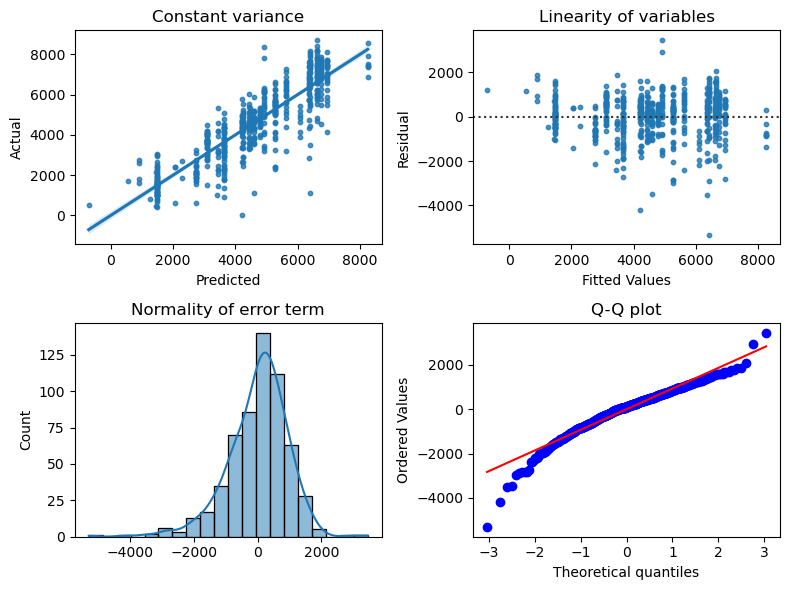

In [160]:
validate_assumption(model1, X_train[['const'] + top_features], X_test[['const'] + top_features])

**Observation:**
- K fold cross validation result is very similar to train/test result, indicating no overfitting.
- All features' VIF is lower than 5, indicating **no multicollinearity**.
- **Mean residual = 0** assumption satisfied.
- Goldfeld–Quandt test verified that **residuals are homoscedastic**. We can also see that on the scatter splot of actual and predicted values.
- Residuals and fitted values plot show no pattern, confirming **the linearity assumption**.
- **Error term is normally distributed**. QQ plot forms mostly a straight line except for a few outliers on the upper and lower end.

## 4.3 Multiple linear regression model 2 (feature selection using RFE with minmax scaler)

### Normalize the data data

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

scaler = MinMaxScaler()

columns_to_scale = ['temp', 'humidity', 'windspeed']

X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

X_train.head()

,const,holiday,workingday,temp,humidity,windspeed,yr_2019,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,Fall,Summer,Winter,Fri,Sat,Sun,Thu,Tue,Wed,Cloudy,Light_rain_snow
140,1.0,0,1,0.677065,0.525883,0.234411,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
600,1.0,0,0,0.801670,0.509412,0.118696,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
118,1.0,0,0,0.561806,0.286470,0.519290,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
254,1.0,0,1,0.729210,0.618363,0.158697,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
92,1.0,0,1,0.397742,0.318823,0.381279,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


### Feature selection with RFE

In [162]:
max_vif_values = []
model = LinearRegression()

# loop to calculate max VIF among n features
for n_features in range(2, X_train.shape[1] + 1):
    rfe = RFE(model, n_features_to_select = n_features)
    rfe.fit(X_train, y_train) 
    # top features selected
    top_n_features = rfe.get_feature_names_out(X_train.columns).tolist()
    # calculate the highest vif values among the selected features
    vif_for_n_features = [vif(X_train[['const'] + top_n_features].values, i) for i in range(n_features+1)]
    max_vif_value = pd.Series(vif_for_n_features[1:]).max()
    max_vif_values = max_vif_values + [max_vif_value]
    if max_vif_value > 50:
        break

df_result = pd.DataFrame({
    'n_features': range(2, len(max_vif_values) + 2),
    'max_vif_value': max_vif_values
})
df_result.sort_values('n_features', ascending=False)

,n_features,max_vif_value
22,24,53.286406
21,23,6.718983
20,22,6.718909
19,21,6.714954
18,20,6.176082
17,19,6.174467
16,18,6.152526
15,17,6.152481
14,16,6.115736
13,15,6.115511


Text(0.5, 1.0, 'Highest VIF value corresponding to n features selected')

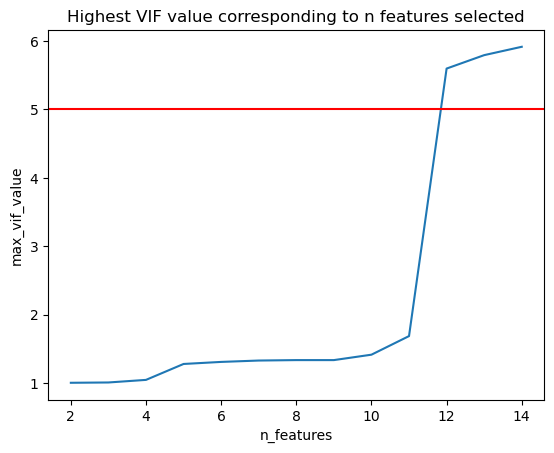

In [163]:
sns.lineplot(data=df_result[df_result.max_vif_value<6], x='n_features', y='max_vif_value')
plt.axhline(5, color='r')
plt.title('Highest VIF value corresponding to n features selected')

Different from unscaled data, choosing more than 12 features with RFE on normalized data will result in VIF > 5 among the selected variables.

**Calculate the top 11 features with RFE**

In [164]:
top_features = rfe_top_features(X_train, y_train, 11)
top_features

Top 11 features:


['holiday',
 'temp',
 'humidity',
 'windspeed',
 'yr_2019',
 'mnth_8',
 'mnth_9',
 'mnth_10',
 'Summer',
 'Winter',
 'Light_rain_snow']

**Check VIF of 11 features above**

In [165]:
checking_vif(X_train[['const'] + top_features])

,feature,VIF
0,const,28.84
10,Winter,1.69
8,mnth_10,1.49
2,temp,1.47
6,mnth_8,1.39
9,Summer,1.36
3,humidity,1.35
7,mnth_9,1.24
11,Light_rain_snow,1.22
4,windspeed,1.19


- All features' VIF are lower than 5.

### Build model 2

In [166]:
model2 = sm.OLS(y_train,X_train[['const']+ top_features]).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     244.6
Date:                Tue, 28 Feb 2023   Prob (F-statistic):          5.38e-208
Time:                        23:06:27   Log-Likelihood:                -4741.3
No. Observations:                 584   AIC:                             9507.
Df Residuals:                     572   BIC:                             9559.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1856.8758    182.348     

**Observation:**
- R-squared and adjusted R-squared were improved from model 1
- All features are statistically significant.

### Check assumption

K fold cross validation: 
     Metrics  R-squared            MSE         MAE
0      Train   0.824656  659573.709245  603.071040
1       Test   0.845388  562306.661512  575.932887
0  Cross_val   0.820655  660961.992822  605.680693

--------------------------------------------------
Check multicollinearity
                   VIF
feature               
const            28.84
Winter            1.69
mnth_10           1.49
temp              1.47
mnth_8            1.39
Summer            1.36
humidity          1.35
mnth_9            1.24
Light_rain_snow   1.22
windspeed         1.19
yr_2019           1.02
holiday           1.01

--------------------------------------------------
Mean residual: -0.0000  (-3.806173032762049e-12)

--------------------------------------------------
Goldfeld–Quandt test of homoscedasticity
-- Hypothesis:
-- H0: Residuals are homoscedastic
-- H1: Residuals have heteroscedasticity
-- (with alpha = 0.05)
--> F-statistic 1.1758, p-value 0.0880
--> Failed to reject H0 (

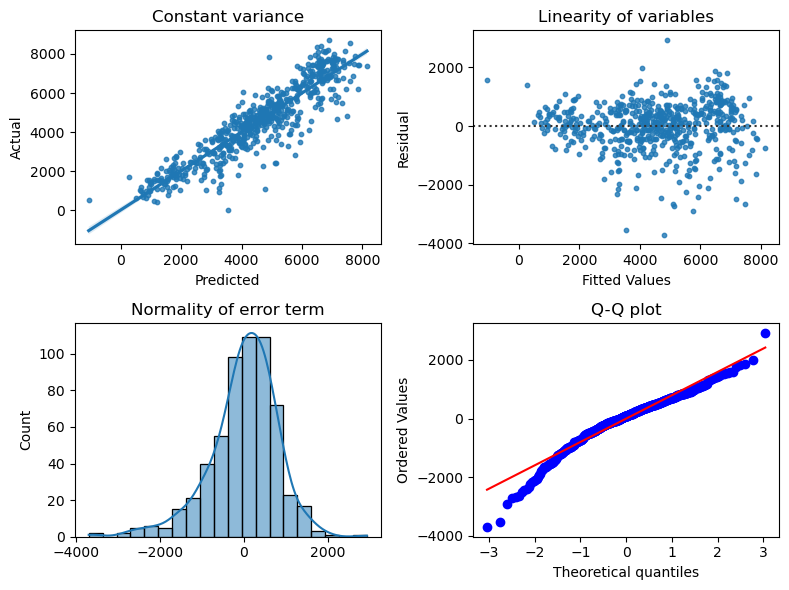

In [74]:
validate_assumption(model2, X_train[['const'] + top_features], X_test[['const'] + top_features])

**Observation:**
- R-squared is similar between train/test set and kfold cross validation, indicating no overfitting
- R-squared is higher and mean squared error/mean absolute error is lower than model 1.
- All features' VIF is lower than 5, indicating **no multicollinearity**.
- **Mean residual = 0** assumption satisfied.
- Goldfeld–Quandt test verified that **residuals are homoscedastic**. We can also see that on the scatter splot of actual and predicted values.
- Residuals and fitted values plot show no pattern, confirming **the linearity of variables assumption**.
- **Error term is normally distributed**. QQ plot forms mostly a straight line except for a few outliers on the lower end.


## 4.4 Multiple linear regression model 3 (feature selection using RFE with standard scaler)

### Scale data

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

scaler = StandardScaler()

columns_to_scale = ['temp', 'humidity', 'windspeed']

X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

X_train.head()

,const,holiday,workingday,temp,humidity,windspeed,yr_2019,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,Fall,Summer,Winter,Fri,Sat,Sun,Thu,Tue,Wed,Cloudy,Light_rain_snow
140,1.0,0,1,0.595169,0.006592,-0.909668,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
600,1.0,0,0,1.140958,-0.077525,-1.560190,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
118,1.0,0,0,0.090314,-1.216084,0.691859,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
254,1.0,0,1,0.823571,0.478888,-1.335314,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
92,1.0,0,1,-0.628311,-1.050856,-0.084005,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


### Feature selection with RFE

In [76]:
max_vif_values = []
model = LinearRegression()

# loop to calculate max VIF among n features
for n_features in range(2, X_train.shape[1] + 1):
    rfe = RFE(model, n_features_to_select = n_features)
    rfe.fit(X_train, y_train) 
    # top features selected
    top_n_features = rfe.get_feature_names_out(X_train.columns).tolist()
    # calculate the highest vif values among the selected features
    vif_for_n_features = [vif(X_train[['const'] + top_n_features].values, i) for i in range(n_features+1)]
    max_vif_value = pd.Series(vif_for_n_features[1:]).max()
    max_vif_values = max_vif_values + [max_vif_value]
    if max_vif_value > 50:
        break

df_result = pd.DataFrame({
    'n_features': range(2, len(max_vif_values) + 2),
    'max_vif_value': max_vif_values
})
df_result.sort_values('n_features', ascending=False)

,n_features,max_vif_value
22,24,53.286406
21,23,6.718983
20,22,6.718909
19,21,6.714954
18,20,6.176082
17,19,6.073704
16,18,6.064863
15,17,6.064858
14,16,6.064059
13,15,6.046487


Text(0.5, 1.0, 'Highest VIF value corresponding to n features selected')

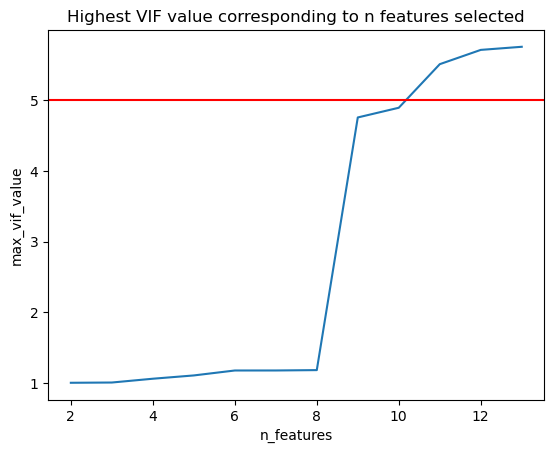

In [77]:
sns.lineplot(data=df_result[df_result.max_vif_value<6], x='n_features', y='max_vif_value')
plt.axhline(5, color='r')
plt.title('Highest VIF value corresponding to n features selected')

Choosing more than 10 features with RFE on standardized data will result in VIF > 5 among the selected variables.

**Calculate the top 10 features with RFE**

In [78]:
top_features = rfe_top_features(X_train, y_train, 10)
top_features

Top 10 features:


['holiday',
 'temp',
 'yr_2019',
 'mnth_9',
 'mnth_10',
 'Fall',
 'Summer',
 'Winter',
 'Cloudy',
 'Light_rain_snow']

**Check VIF of 10 features above**

In [79]:
checking_vif(X_train[['const'] + top_features])

,feature,VIF
0,const,9.65
6,Fall,4.89
2,temp,3.39
7,Summer,2.57
8,Winter,2.14
5,mnth_10,1.51
4,mnth_9,1.17
9,Cloudy,1.05
10,Light_rain_snow,1.05
3,yr_2019,1.02


- All features' VIF are lower than 5.

### Build model 3

In [80]:
model3 = sm.OLS(y_train,X_train[['const']+ top_features]).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     253.3
Date:                Tue, 28 Feb 2023   Prob (F-statistic):          6.30e-203
Time:                        22:47:18   Log-Likelihood:                -4756.1
No. Observations:                 584   AIC:                             9534.
Df Residuals:                     573   BIC:                             9582.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2889.0809    108.123     

**Observation:**
- All features's p-value < 0.5
- R-squared is 0.816

### Check assumption

K fold cross validation: 
     Metrics  R-squared            MSE         MAE
0      Train   0.815528  693908.429729  617.047811
1       Test   0.842581  572514.705256  592.780554
0  Cross_val   0.812199  690666.701692  620.609323

--------------------------------------------------
Check multicollinearity
                  VIF
feature              
const            9.65
Fall             4.89
temp             3.39
Summer           2.57
Winter           2.14
mnth_10          1.51
mnth_9           1.17
Cloudy           1.05
Light_rain_snow  1.05
yr_2019          1.02
holiday          1.01

--------------------------------------------------
Mean residual: -0.0000  (-1.8812835612015363e-12)

--------------------------------------------------
Goldfeld–Quandt test of homoscedasticity
-- Hypothesis:
-- H0: Residuals are homoscedastic
-- H1: Residuals have heteroscedasticity
-- (with alpha = 0.05)
--> F-statistic 1.2569, p-value 0.0279
--> Reject H0 (p_value<0.05)

------------------------------

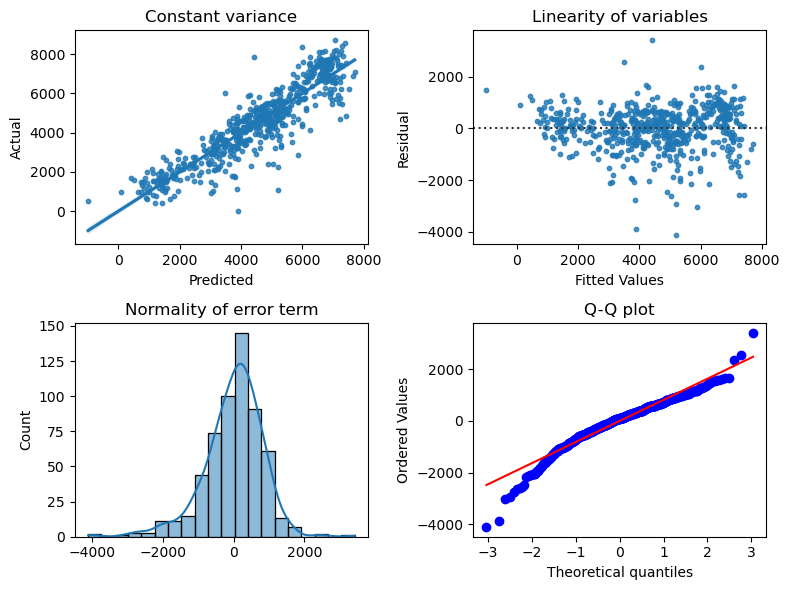

In [81]:
validate_assumption(model3, X_train[['const'] + top_features], X_test[['const'] + top_features])

**Observation:**
- The model 3 built with this set of features ('holiday','feel_temp', 'yr_2019', 'mnth_9', 'mnth_10', 'Fall', 'Summer', 'Winter', 'Cloudy', 'Light_rain_snow') violated the assumption of homoscedasticity

# 5. Conclusion

## 5.1 Summary of what have been done

1. Check the data quality
2. Process the data for EDA
3. Perform EDA on categorical and numerical features
4. Treat possible outliers or wrong values
5. Preprocess the data for modelling: convert categorical data to dummies, transform the numerical features with min-max scaler and standard scaler, etc
6. Perform feature selection with RFE
7. Check multicollinearity with VIF
8. Build and tune models
9. Check model assumptions

## 5.2 Model selection and interpretation

### Model selection

From the models we have, model2 has the highest R^2, lowest MSE/MAE, satisfied all assumptions. It was able to capture ~83% variations in our data based on kfold cross validation.

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)
scaler = MinMaxScaler()
columns_to_scale = ['temp', 'humidity', 'windspeed']
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [83]:
# get features
model2_features = model2.params.index.tolist()

# make prediction on test set
yhat_test  = model2.predict(X_test[model2_features])

# R2
print(f'Model 2\'s R-squared on test set: {r2_score(y_test, yhat_test):.4f}')

Model 2's R-squared on test set: 0.8454


In [84]:
model_performance(model2, X_train[model2_features],X_test[model2_features])

,Metrics,R-squared,MSE,MAE
0,Train,0.824656,659573.709245,603.071040
1,Test,0.845388,562306.661512,575.932887


### Model's interpretation

In [85]:
# Equation of the fit
coef = model2.params

print('Model 2\'s equation:')
print("Count = ", end=' ')

print(f'({coef[0]:.1f})*{coef.index[0]}', end = ' ')
for i in range(1, len(coef)):
    print(f' + ({coef[i]:.1f})*{coef.index[i]}', end = ' ')

Model 2's equation:
Count =  (1856.9)*const  + (-540.1)*holiday  + (4759.8)*temp  + (-1893.0)*humidity  + (-1381.1)*windspeed  + (1978.1)*yr_2019  + (483.2)*mnth_8  + (1199.8)*mnth_9  + (428.3)*mnth_10  + (925.9)*Summer  + (1145.2)*Winter  + (-1329.7)*Light_rain_snow 

In [86]:
# sort coefficient
coef.sort_values(key=abs, ascending=False)

temp               4759.839809
yr_2019            1978.116109
humidity          -1892.982252
const              1856.875815
windspeed         -1381.143477
Light_rain_snow   -1329.669560
mnth_9             1199.773747
Winter             1145.210483
Summer              925.926390
holiday            -540.070940
mnth_8              483.199592
mnth_10             428.320479
dtype: float64

**Coefficient interpretation**

In [87]:
# convert coefficient for min-max to per unit of measurement for numerical variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

for feature, coef in [('temp',4759.839), ('humidity',1892.98), ('windspeed',-1381.143)]:
    print(feature)
    feature_max = X_train[feature].max()
    feature_min = X_train[feature].min()
    feature_range = feature_max - feature_min
    change_per_1_unit = coef/feature_range
    print(f'Max: {feature_max:.2f}, min: {feature_min:.2f}')
    print(f'Change per 1 unit: {change_per_1_unit:.2f}')

temp
Max: 35.33, min: 2.42
Change per 1 unit: 144.66
humidity
Max: 96.25, min: 25.42
Change per 1 unit: 26.72
windspeed
Max: 29.58, min: 1.50
Change per 1 unit: -49.18


The model indicates that the most significant predictors of the number of rented bikes are:
- **temperature** 
- **year**
- **humidity**
- **windspeed**
- **Light_rain_snow** weather

1. temp: warmer weather has a positive correlation to usage. Each **1 degree increase in temp lead to 144 more rented bikes**, <br> as the coefficient for normalized data (0 for min and 1 for max) is 4759 and the range between max (35.33) and min (2.42) value is 32.91. <br> 4759/32.91 = ~144.6 (bikes per degree)
2. humidity: each **percent increase in humidity leads to 26.72 decreased rented bikes**.
3. windspeed: each **unit increase in wind speed leads to 49.18 decreased rented bikes**.
4. Light_rain_snow weather will lead to **a decrease of 1330 rented bikes**, when everything else is constant.
5. year 2019 see an **increase of 1978 rented bikes daily compared to 2018**, when everything else is constant. (Note: this is NOT a per year increase, meaning it can NOT be interpreted as 'each year passed by leads to an increase of 1978 in daily rents'. It only explained the increase in popularity/demand in 2019).
6. holiday sees a **negative correlation with daily usage**, decrease 540 in rented bikes, when everything else is constant.
7. As for the rest (month 8, month 9, month 10, Summer, Winter) explained the **monthly/seasonal increase in demand compared to the reference category (Spring/month 1)**, when everything else is constant.

### Assess feature importance by change in R^2 after removing a variable

Besides looking at coeffients, another way to assess feature importance is the change of R^2 when removed said variable from the original model. **The change in R squared represents the percentage of the variance that variable explained that the other variables in the model could not**.

In other words, this change in R-squared represents the amount of unique variance that each variable explains above and beyond the other variables in the model.

In [88]:
model2_features = model2.params.index.tolist()[1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)
scaler = MinMaxScaler()
columns_to_scale = ['temp', 'humidity', 'windspeed']

X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [89]:
r2_after_remove = []
for feature in model2_features:
    # remove the feature one by one from original features
    remaining_features = model2_features.copy()
    remaining_features.remove(feature)
    
    model = sm.OLS(y_train,X_train[['const']+ remaining_features]).fit()
    r2_after_remove.append(model.rsquared)
df_features_importance = pd.DataFrame({
    'Variable removed': model2_features,
    'R2 after removed': r2_after_remove
})
df_features_importance['Change in R2 by variable'] = r2_score(y_test, yhat_test) - df_features_importance['R2 after removed']
df_features_importance.sort_values('R2 after removed')

,Variable removed,R2 after removed,Change in R2 by variable
4,yr_2019,0.570416,0.274971
1,temp,0.610997,0.234391
9,Winter,0.784499,0.060888
8,Summer,0.794658,0.050730
2,humidity,0.797581,0.047807
6,mnth_9,0.799978,0.045410
3,windspeed,0.811145,0.034243
10,Light_rain_snow,0.813126,0.032262
5,mnth_8,0.821150,0.024238
7,mnth_10,0.821955,0.023432


- We can see that **year 2019** and **feel_temp** has the highest 'unique explained' variance, followed by **Winter** and **Summer**.
- **Holiday** is ranked last.

# 6. (Extra) Investigate high-residual predictions

In [90]:
df_residual = df_eda.copy() # load the non-dummied data from eda

df_residual['predicted'] = model2.fittedvalues
df_residual['residuals'] = model2.resid
df_residual['abs_residuals'] = df_residual['residuals'].abs()
df_residual['percentage_error'] = (100*df_residual.abs_residuals / df_residual.cnt).round(2)

# Top 30 predictions with highest residual
df_residual = df_residual.sort_values('abs_residuals', ascending=False).head(30)

df_residual[['instant', 'dteday','season','mnth','holiday','weekday','workingday','weather','temp','humidity','windspeed', 'cnt','predicted','residuals','percentage_error']]

,instant,dteday,season,mnth,holiday,weekday,workingday,weather,temp,humidity,windspeed,cnt,predicted,residuals,percentage_error
667,668,2019-10-30,Winter,10,0,Wed,1,Cloudy,13.045462,82.5455,14.271603,1096,4790.147406,-3694.147406,337.06
666,667,2019-10-29,Winter,10,0,Tue,1,Light_rain_snow,18.040000,88.0000,23.999400,22,3558.815716,-3536.815716,16076.44
440,441,2019-03-17,Spring,3,0,Sun,0,Cloudy,21.080847,75.5833,7.417168,7836,4902.152046,2933.847954,37.44
498,499,2019-05-14,Summer,5,0,Tue,1,Cloudy,23.506653,78.9583,14.250364,2843,5752.752407,-2909.752407,102.35
690,691,2019-11-22,Winter,11,1,Fri,0,Clear,13.940000,58.0417,3.542344,2425,5133.654885,-2708.654885,111.70
693,694,2019-11-25,Winter,11,0,Mon,1,Clear,10.079153,46.8333,10.083500,2424,5093.078264,-2669.078264,110.11
552,553,2019-07-07,Fall,7,0,Sun,0,Clear,35.328347,49.2083,10.958118,4840,7493.892846,-2653.892846,54.83
553,554,2019-07-08,Fall,7,0,Mon,1,Clear,33.722500,57.3750,8.417143,4672,7168.303416,-2496.303416,53.43
692,693,2019-11-24,Winter,11,0,Sun,0,Clear,11.411653,40.4583,25.250357,2277,4710.325627,-2433.325627,106.87
644,645,2019-10-07,Winter,10,0,Mon,1,Cloudy,17.049153,70.8333,9.457854,3510,5919.048636,-2409.048636,68.63


Are they underpredicted or overpredicted?

In [91]:
(df_residual.residuals<0).map({True: 'Overpredicted', False: 'Underpredicted'}).value_counts()

Overpredicted     25
Underpredicted     5
Name: residuals, dtype: int64

Where are they?

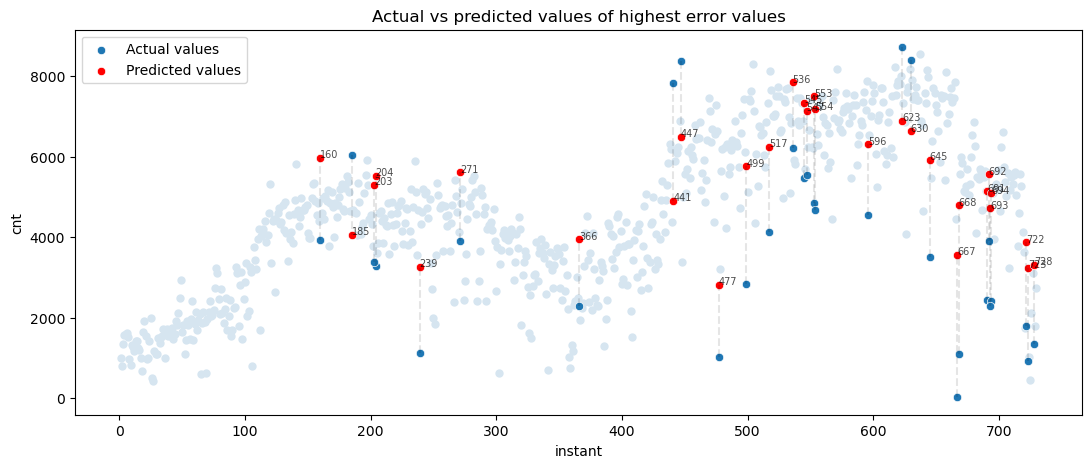

In [92]:
plt.figure(figsize=(13,5))
# all data point
ax = sns.scatterplot(data=df_eda, x='instant', y='cnt', color='#d6e5f0', linewidth=0)
# actual values
sns.scatterplot(data = df_residual, y='cnt', x='instant', color='#1f77b4', label='Actual values', ax=ax)
# predicted values
sns.scatterplot(data = df_residual, y='predicted', x='instant', ax=ax, color='r', label='Predicted values')

# plot the line connecting the two
for x,y1,y2 in zip(df_residual.instant,df_residual.cnt,df_residual.predicted):
    plt.plot((x,x), (y1,y2), linestyle="--", color='black', alpha=0.1)
    plt.annotate(x, xy=(x,y2), size=7, alpha=0.7)

plt.title('Actual vs predicted values of highest error values')

plt.legend()

See the days before/after the high error prediction:

In [93]:
# 160 unsure, heat?
# 185 due to holiday
# 203-205 heat? feel_temp reach 40
# 239 unsure
# 366 holiday
# 441-447: alternate between clear and cloudy/mist.
# 477 is the rain
# 499 unsure
# 517 unsure
# 553 is holiday related
# 596 change in weather
# 623 low percentage error
# 630 low percentage error
# 645: monday before holiday
# 667, 668: snow/rain
# 691 - 694: holiday on friday
# 722,723 xmas 
# 728

# replace the number above to datapoint_instant:
datapoint_instant = 722
print(df_residual[df_residual.instant == datapoint_instant][['instant', 'cnt','predicted','residuals','percentage_error']])
df_eda[df_eda.instant.isin(range(datapoint_instant-5,datapoint_instant+5))]

     instant   cnt    predicted    residuals  percentage_error
721      722  1787  3879.426234 -2092.426234            117.09


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,cnt,casual_to_reg_ratio
716,717,2019-12-18,Winter,2019,12,0,Wed,1,Clear,16.844153,20.48540,66.6250,14.834068,433,5124,5557,0.084504
717,718,2019-12-19,Winter,2019,12,0,Thu,1,Clear,13.632500,17.10810,62.5417,12.334164,333,4934,5267,0.067491
718,719,2019-12-20,Winter,2019,12,0,Fri,1,Cloudy,13.530000,16.76085,66.7917,8.875021,314,3814,4128,0.082328
719,720,2019-12-21,Spring,2019,12,0,Sat,0,Cloudy,13.393347,15.08835,55.6667,25.083661,221,3402,3623,0.064962
720,721,2019-12-22,Spring,2019,12,0,Sun,0,Clear,10.899153,11.80565,44.1250,27.292182,205,1544,1749,0.132772
721,722,2019-12-23,Spring,2019,12,0,Mon,1,Clear,10.079153,12.97355,51.5417,8.916561,408,1379,1787,0.295867
722,723,2019-12-24,Spring,2019,12,0,Tue,1,Cloudy,9.483464,12.94500,79.1304,5.174437,174,746,920,0.233244
723,724,2019-12-25,Spring,2019,12,1,Wed,0,Cloudy,11.943464,14.72325,73.4783,11.304642,440,573,1013,0.767888
724,725,2019-12-26,Spring,2019,12,0,Thu,1,Light_rain_snow,9.976653,11.01665,82.3333,21.208582,9,432,441,0.020833
725,726,2019-12-27,Spring,2019,12,0,Fri,1,Cloudy,10.420847,11.33210,65.2917,23.458911,247,1867,2114,0.132298


We can see that many of the high error prediction is overpredictions due to holiday and weather. 

- When a normal day is between a holiday and weekend, people may take that day off to have a 'prolonged holiday' (eg Thursday is holiday, take Friday off also, to have 4 consecutive days off).
- Some other are related to Christmas - New year's Eve period
- Days after a rain/snow can have high error, as people might take other means of transport, for precaution.

***
End of analysis. Thank you.